# Imports and utility functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sps
import scipy.optimize as opt

In [2]:
def ssd(sample):
    var = np.var(sample)
    return np.sqrt(var * len(sample) / (len(sample) - 1))

def sem(sample):
    return ssd(sample) / np.sqrt(len(sample))

def paste(arr):
#     print('mean:', np.mean(arr),
#           'sd:', ssd(arr),
#           'sem:', sem(arr))
    print('mean±sem: {m:.3f} ± {e:.3f}'.format(m=np.mean(arr), e=sem(arr)))
    return np.mean(arr), sem(arr)

# Data: Torsional Pendulum

## Data: Diameter

In [4]:
disk_diams = [26.00, 26.00, 26.10, 26.10, 26.00]
paste(disk_diams)

mean±sem: 26.040 ± 0.024


(26.04, 0.02449489742783213)

## Data: Oscillations

In [6]:
mean_times, time_errors = [], []
masses = [50, 70, 110, 150, 190, 230]

t0 = [7.77, 7.87, 7.87, 7.87, 7.82]
t, e = paste(t0)
mean_times += [t]
time_errors += [e]

t1 = [9.36, 9.48, 9.45, 9.45, 9.39]
t, e = paste(t1)
mean_times += [t]
time_errors += [e]

t3 = [12.11, 12.12, 12.11, 12.24, 12.16]
t, e = paste(t3)
mean_times += [t]
time_errors += [e]

t5 = [14.37, 14.27, 14.20, 14.29, 14.24]
t, e = paste(t5)
mean_times += [t]
time_errors += [e]

t7 = [16.32, 16.33, 16.36, 16.30, 16.27]
t, e = paste(t7)
mean_times += [t]
time_errors += [e]

t9 = [17.89, 17.99, 17.94, 17.92, 18.12]
t, e = paste(t9)
mean_times += [t]
time_errors += [e]

mean±sem: 7.840 ± 0.020
mean±sem: 9.426 ± 0.022
mean±sem: 12.148 ± 0.025
mean±sem: 14.274 ± 0.028
mean±sem: 16.316 ± 0.015
mean±sem: 17.972 ± 0.040


## Preliminary Analyses

In [8]:
mean_sg_times = [mt / 10 for mt in mean_times]
sg_time_errors = [er / 10 for er in time_errors]
mean_sg_times, sg_time_errors

([0.784,
  0.9425999999999999,
  1.2147999999999999,
  1.4274,
  1.6316,
  1.7972000000000001],
 [0.0020000000000000083,
  0.0022045407685048614,
  0.002477902338672791,
  0.00283901391331567,
  0.0015033296378372779,
  0.00404227658628154])

In [9]:
sq_times = [t**2 for t in mean_sg_times]
sq_times

[0.6146560000000001,
 0.8884947599999998,
 1.4757390399999997,
 2.03747076,
 2.6621185599999997,
 3.2299278400000007]

In [10]:
alpha_t_sq = [2 * mean_sg_times[i] * sg_time_errors[i] for i in range(len(mean_sg_times))]
alpha_t_sq

[0.003136000000000013,
 0.004156000256785364,
 0.006020311522039412,
 0.008104816919733575,
 0.004905665274190605,
 0.014529558961730369]

In [13]:
m_holder, d_holder, m_disk, d_disk = 50e-3, 26e-3, 20e-3, 26.04e-3
m_holder, d_holder, m_disk, d_disk
a_mh, a_dh, a_md, a_dd = 0.1e-3, 0.02e-3, 0.1e-3, 0.05e-3

In [14]:
I_tots = [1/8 * (m_holder * d_holder**2 + n * m_disk * d_disk**2) for n in range(6)]
I_tots

[4.225e-06,
 5.920204000000001e-06,
 7.615408e-06,
 9.310612000000001e-06,
 1.1005816000000001e-05,
 1.270102e-05]

In [16]:
a_I_h = 1/8 * m_holder * d_holder**2 * np.sqrt((a_mh / m_holder)**2 + (a_dh / d_holder)**2)
a_I_d = 1/8 * m_disk * d_disk**2 * np.sqrt((a_md / m_disk)**2 + (a_dd / d_disk)**2)
a_I_h, a_I_d

(9.053452380169679e-09, 9.07953413124264e-09)

In [17]:
alpha_I_tots = [(np.sqrt((a_I_h)**2 + n * (a_I_d)**2)) for n in range(6)]
alpha_I_tots

[9.053452380169679e-09,
 1.2821970988908065e-08,
 1.571117055094241e-08,
 1.8146041444932285e-08,
 2.0290804817985908e-08,
 2.222959064404921e-08]

## Adjusted errors

In [84]:
m_simple = 3.27e-6
a_simple = 0.011e-6
alpha_I_adj = [np.sqrt((alpha_I_tots[i])**2+(m_simple * alpha_t_sq[i])**2) for i in range(6)]
print(alpha_I_adj)
kappa_0 = m_simple * 4 * np.pi**2
a_k0 = a_simple * 4 * np.pi**2
kappa_0, a_k0

[1.3679337786545111e-08, 1.868406605848218e-08, 2.518721819514109e-08, 3.211969252732705e-08, 2.586594863552506e-08, 5.2454859904187654e-08]


(0.0001290944255662488, 4.342625936479317e-07)

# Regression Analysis

In [18]:

#proportional model y=mx
def model_prop(x,m):
    return m*x

#linear model y=mx+c
def model_lin(x,m,c):
    return m*x + c

# Calculating the chisq (*not reduced*)
def chisq(predicted, observed, errors):
    res = observed-predicted
    print(res, errors)
    norm_res = res / errors 
    return np.sum(norm_res**2)

def red_chisq(raw_chisq, v):
    return raw_chisq / v

In [73]:
x_dat = np.array(sq_times)
y_dat = np.array(I_tots)
y_err = np.array(alpha_I_tots) # for simple linreg
y_err = np.array(alpha_I_adj) # for weighted linreg

## Simple linreg

In [36]:
# Fit the initial y=ax model to the data and display results
prop_opt, prop_cov = opt.curve_fit(model_prop, x_dat, y_dat, p0=[0.025])

# Extracting the standard errors in the fit parameters, from the covariance matrix diagonal
prop_err = np.sqrt(np.diag(prop_cov))

# Displaying   ("\u00B1" is the plus/minus symbol)
# We're using string formatting with the "%" to limit the # of digits... just look it up

print("a = %5.9f \u00b1 %5.12f N m" % (prop_opt[0], prop_err[0]))

a = 0.000004333 ± 0.000000288407 N m


[ 1.56182085e-06  2.07053733e-06  1.22133157e-06  4.82666540e-07
 -5.28601041e-07 -1.29359890e-06] [9.05345238e-09 1.28219710e-08 1.57111706e-08 1.81460414e-08
 2.02908048e-08 2.22295906e-08]


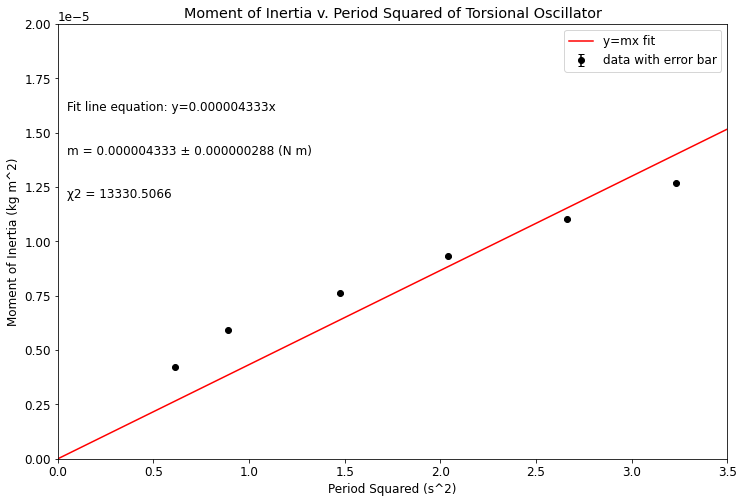

In [43]:
# Plot data with best-fit for the model y=ax
plt.figure(figsize=(12, 8))
plt.plot(np.linspace(0,3.5),model_prop(np.linspace(0,3.5), prop_opt[0]),'r-', label="y=mx fit")
plt.errorbar(x_dat, y_dat, yerr=y_err, fmt='ko', capsize = 3, capthick = 1, label="data with error bar")
plt.xlabel('Period Squared (s^2)')
plt.ylabel('Moment of Inertia (kg m^2)')
plt.title("Moment of Inertia v. Period Squared of Torsional Oscillator")
plt.xlim(0,3.5)
plt.ylim(0,2e-5)
plt.legend()
plt.text(.05,1.6e-5, "Fit line equation: y=%5.9fx" %(prop_opt[0]))
plt.text(.05,1.4e-5, "m = %5.9f \u00b1 %5.9f (N m)" % (prop_opt[0], prop_err[0]))
y_prop = model_prop(x_dat, prop_opt[0])
chi2_prop = chisq(y_prop, y_dat, y_err)
plt.text(.05,1.2e-5, "χ2 = %5.4f" % (red_chisq(chi2_prop, 5)))

# plt.show()
plt.savefig('fig1.png')

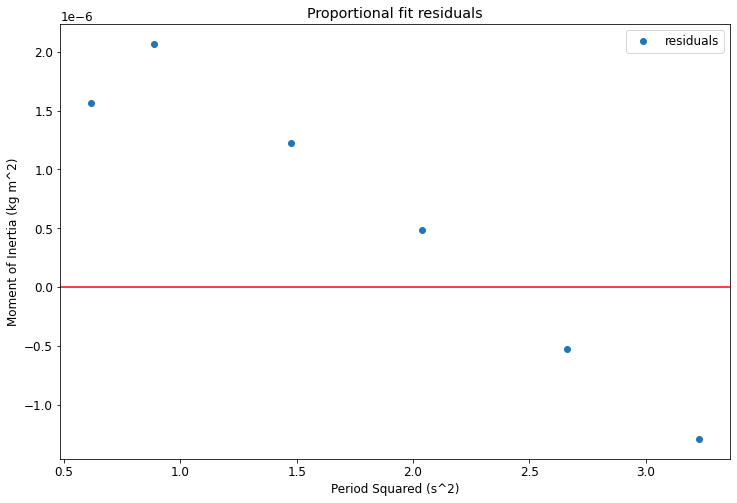

In [37]:
# Predicted y values from the fit to model y=ax
y_prop = model_prop(x_dat, prop_opt[0])

# Proportional model residuals defined
r_prop = y_dat - y_prop

# Sets figure size etc. by starting with plt.figure
fig2=plt.figure(figsize=(12, 8), facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': '12'})

# Residuals without error bars
plt.errorbar(x_dat, r_prop, yerr=None, fmt='o', label='residuals')
plt.axhline(color='r') # 0 line for reference

# Axes label and title
plt.title("Proportional fit residuals")
plt.xlabel('Period Squared (s^2)')
plt.ylabel('Moment of Inertia (kg m^2)')
plt.legend()
# plt.show()
plt.savefig('fig2.png')

## Simple linear regression: two-param

In [38]:
# The order of the parameter array elements p0, lin_opt, and lin_cov
# are determined by their order [m,b] in the model definition, model_lin(x,m,b):
# we are using an unweighted fit

# Set initial parameters mInit and bInit
mInit=0.025
cInit=-0.05

#fit the unweighted model y=mx+b
lin_opt, lin_cov = opt.curve_fit(model_lin, x_dat, y_dat, p0=[mInit,cInit])

In [40]:
# Predicted values
y_lin = model_lin(x_dat, lin_opt[0], lin_opt[1])

#error in the fit variables
lin_err = np.sqrt(np.diag(lin_cov))  

print('m = {0:6.9f} ± {1:5.12f}'.format(lin_opt[0], lin_err[0]))
print(f"c = {lin_opt[1]:.6f} ±  {lin_err[1]:.6f}")


m = 0.000003100 ± 0.000000150671
c = 0.000003 ±  0.000000


In [41]:
#chi squared for linear case
chi2_lin = chisq(y_lin, y_dat, y_err)

print('χ2 =', chi2_lin) #unformatted, as an example

red_chi2_lin = red_chisq(chi2_lin, 4)
print('χ~2 =', red_chi2_lin)

[-5.07176842e-07  3.39068636e-07  2.13690203e-07  1.67406143e-07
 -7.39311744e-08 -1.39056965e-07] [9.05345238e-09 1.28219710e-08 1.57111706e-08 1.81460414e-08
 2.02908048e-08 2.22295906e-08]
χ2 = 4160.082183433594
χ~2 = 1040.0205458583985


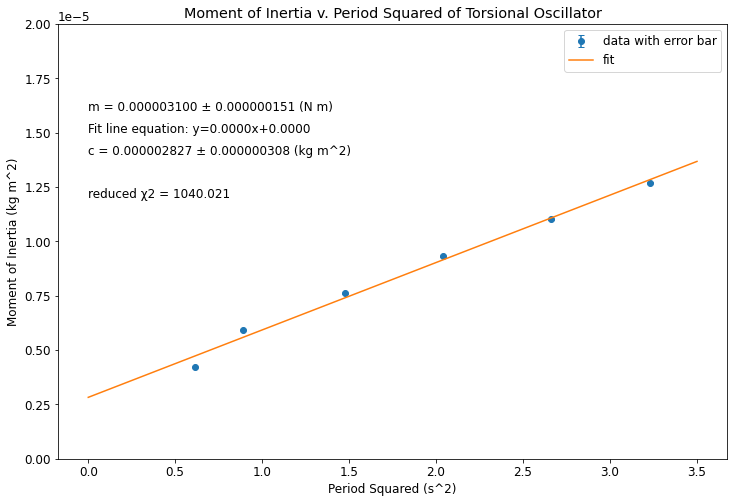

In [47]:
# Best-fit plot with error bars, parameters, chisq

# Sets figure size etc.
fig1 = plt.figure(figsize=(12, 8), facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': '12'})

# Data with error bars
plt.errorbar(x_dat, y_dat, y_err, fmt='o', capsize=3,
             capthick=1, label="data with error bar")

# Best linear fit
# could also use: plt.plot(np.linspace(0,10), model_lin(np.linspace(0,10), lin_opt[0], lin_opt[1]), label='fit')
plt.errorbar(np.linspace(0, 3.5), model_lin(
    np.linspace(0, 3.5), lin_opt[0], lin_opt[1]), label='fit')

# Axes label and title
plt.xlabel('Period Squared (s^2)')
plt.ylabel('Moment of Inertia (kg m^2)')
plt.title("Moment of Inertia v. Period Squared of Torsional Oscillator")
# 
# Best fit parameters, uncertainties, and chisq
plt.text(0, 1.6e-5, "m = %5.9f \u00b1 %5.9f (N m)" % (lin_opt[0], lin_err[0]))
plt.text(0, 1.4e-5, "c = %5.9f \u00b1 %5.9f (kg m^2)" % (lin_opt[1], lin_err[1]))
plt.text(0, 1.2e-5, "reduced χ2 = %5.3f" % red_chi2_lin)

plt.text(0, 1.5e-5, "Fit line equation: y=%5.4fx+%5.4f" %
         (lin_opt[0], lin_opt[1]))

plt.ylim(0, 2e-5)

# plt.text(.5, .01, "ΔL = %1.2f \u00b1 %5.4f m" % (y_dat[0], y_err[0]))
# plt.text(.8, .03, "ΔL = %1.2f \u00b1 %5.4f m" % (y_dat[1], y_err[1]))
# plt.text(1.25, .06, "ΔL = %1.2f \u00b1 %5.4f m" % (y_dat[2], y_err[2]))
# plt.text(1.6, .09, "ΔL = %1.2f \u00b1 %5.4f m" % (y_dat[3], y_err[3]))
# plt.text(1.9, .12, "ΔL = %1.2f \u00b1 %5.4f m" % (y_dat[4], y_err[4]))
# plt.text(1.8, .17, "ΔL = %1.2f \u00b1 %5.4f m" % (y_dat[5], y_err[5]))

plt.legend()
plt.savefig('fig3.png')

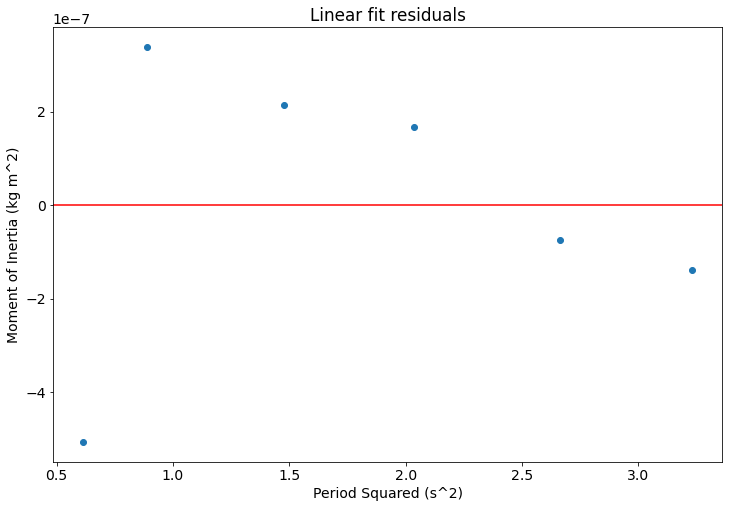

In [49]:
# Residuals plot

# Residuals
r_lin = y_dat- y_lin

# Sets figure size etc.
fig2=plt.figure(figsize=(12, 8), facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': '14'})

# Residuals
plt.errorbar(x_dat, r_lin, fmt='o')
plt.axhline(color='r') # 0 line for reference

# Axes label and title
plt.title("Linear fit residuals")
plt.xlabel('Period Squared (s^2)')
plt.ylabel('Moment of Inertia (kg m^2)')
# plt.show()
plt.savefig('fig4.png')

## Weighted LSQ

In [74]:
# The order of the parameter array elements p0, lin_opt, and lin_cov
# are determined by their order [m,b] in the model definition, model_lin(x,m,b):
# we are using an unweighted fit

# Set initial parameters mInit and bInit
mInit=0.025
bInit=-0.05

#fit the weighted model y=mx+b
lin_opt, lin_cov = opt.curve_fit(model_lin, x_dat, y_dat, p0=[mInit,bInit], sigma=y_err, absolute_sigma=True)

In [75]:
# Predicted values
y_lin = model_lin(x_dat, lin_opt[0], lin_opt[1])

#error in the fit variables
lin_err = np.sqrt(np.diag(lin_cov))  

print('m = {0:6.9f} ± {1:5.12f}'.format(lin_opt[0], lin_err[0]))
print(f"c = {lin_opt[1]:.6f} ±  {lin_err[1]:.6f}")


m = 0.000003267 ± 0.000000011146
c = 0.000003 ±  0.000000


In [76]:
#chi squared for linear case
chi2_lin = chisq(y_lin, y_dat, y_err)

print('χ2 =', chi2_lin) #unformatted, as an example

red_chi2_lin = red_chisq(chi2_lin, 4)
print('χ~2 =', red_chi2_lin)

[-2.96414265e-07  5.04087628e-07  2.80612568e-07  1.40493645e-07
 -2.05188395e-07 -3.65164280e-07] [1.32843708e-08 1.81766364e-08 2.43956383e-08 3.09925967e-08
 2.53571827e-08 5.02285117e-08]
χ2 = 1538.165718346259
χ~2 = 384.54142958656473


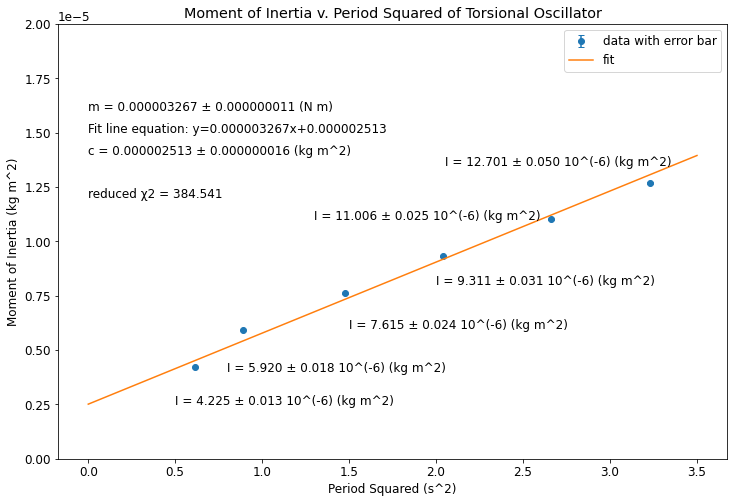

In [77]:
# Best-fit plot with error bars, parameters, chisq
labels_dat = [y * 1e6 for y in y_dat]
labels_err = [y * 1e6 for y in y_err]

# Sets figure size etc.
fig1 = plt.figure(figsize=(12, 8), facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': '12'})

# Data with error bars
plt.errorbar(x_dat, y_dat, y_err, fmt='o', capsize=3,
             capthick=1, label="data with error bar")

# Best linear fit
# could also use: plt.plot(np.linspace(0,10), model_lin(np.linspace(0,10), lin_opt[0], lin_opt[1]), label='fit')
plt.errorbar(np.linspace(0, 3.5), model_lin(
    np.linspace(0, 3.5), lin_opt[0], lin_opt[1]), label='fit')

# Axes label and title
plt.xlabel('Period Squared (s^2)')
plt.ylabel('Moment of Inertia (kg m^2)')
plt.title("Moment of Inertia v. Period Squared of Torsional Oscillator")

# Best fit parameters, uncertainties, and chisq
plt.text(0, 1.6e-5, "m = %5.9f \u00b1 %5.9f (N m)" % (lin_opt[0], lin_err[0]))
plt.text(0, 1.4e-5, "c = %5.9f \u00b1 %5.9f (kg m^2)" % (lin_opt[1], lin_err[1]))
plt.text(0, 1.2e-5, "reduced χ2 = %5.3f" % red_chi2_lin)

plt.text(0, 1.5e-5, "Fit line equation: y=%5.9fx+%5.9f" %
         (lin_opt[0], lin_opt[1]))

plt.ylim(0, 2e-5)

plt.text(.5, 0.25e-5, "I = %1.3f \u00b1 %5.3f 10^(-6) (kg m^2)" % (labels_dat[0], labels_err[0]))
plt.text(.8, 0.4e-5, "I = %1.3f \u00b1 %5.3f 10^(-6) (kg m^2)" % (labels_dat[1], labels_err[1]))
plt.text(1.5, 0.6e-5, "I = %1.3f \u00b1 %5.3f 10^(-6) (kg m^2)" % (labels_dat[2], labels_err[2]))
plt.text(2, 0.8e-5, "I = %1.3f \u00b1 %5.3f 10^(-6) (kg m^2)" % (labels_dat[3], labels_err[3]))
plt.text(1.3, 1.1e-5, "I = %1.3f \u00b1 %5.3f 10^(-6) (kg m^2)" % (labels_dat[4], labels_err[4]))
plt.text(2.05, 1.35e-5, "I = %1.3f \u00b1 %5.3f 10^(-6) (kg m^2)" % (labels_dat[5], labels_err[5]))

plt.legend()
plt.savefig('fig5.png')

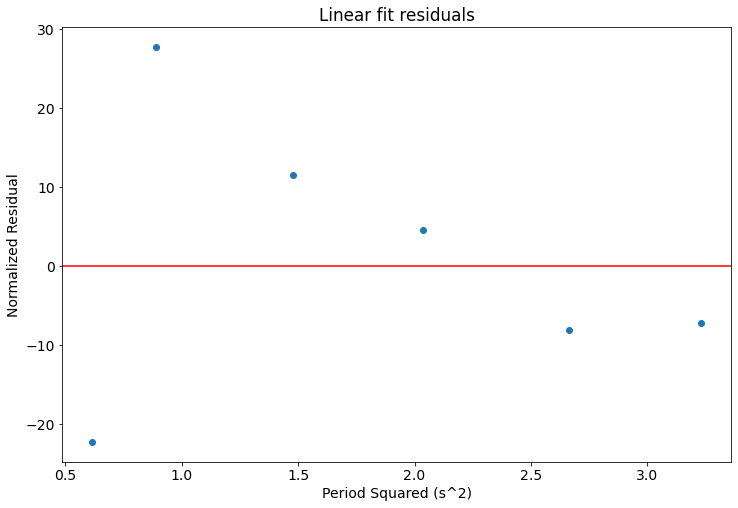

In [81]:
# Residuals plot

# Residuals, normalized
r_lin = [(y_dat[i] - y_lin[i]) / y_err[i] for i in range(6)]

# Sets figure size etc.
fig2=plt.figure(figsize=(12, 8), facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': '14'})

# Residuals
plt.errorbar(x_dat, r_lin, fmt='o', label='residuals with error bars')
plt.axhline(color='r') # 0 line for reference

# Axes label and title
plt.title("Linear fit residuals")
plt.xlabel('Period Squared (s^2)')
plt.ylabel('Normalized Residual')
# plt.show()
plt.savefig('fig6.png')

In [5]:
'±'

'±'